## Классификация вероятности срыва на всём контракте

В этом ноутбуке мы аггрегируем признаки на уровне контракта и делаем классификацию по всей последовательности сразу. Полезно для проверки различных общих гипотез и блендинга.

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from datetime import datetime
from sklearn.linear_model import LinearRegression
import pickle


from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

import optuna

pd.options.display.max_columns = 120

/Users/bondarchukgleb/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
X_train = pd.read_csv("data_final/train_X.csv")
y_train_all = pd.read_csv("data_final/train_y.csv")

train = X_train.merge(y_train_all, on=["contract_id", "report_date"], how="left")
y_train_all = train["default6"]

train_orig = deepcopy(train)

In [3]:
test = pd.read_csv("data_final/test2_X.csv")

In [4]:
always_const_f = pickle.load(open("generated_features/constant_features_list.pickle", "rb"))

In [5]:
# Добавим графовые признаки, аггрегированные по contractor_id

graph_cols = []
graph_features = pd.read_csv("generated_features/contractor_graph_features_v2.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")
graph_cols.extend(graph_features.drop("contractor_id", axis=1).columns)

graph_features = pd.read_csv("generated_features/contractor_graph_features_v3.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")
graph_cols.extend(graph_features.drop("contractor_id", axis=1).columns)

#always_const_f.extend(graph_cols)

In [6]:
all_data = pd.concat([train, test], axis=0)

Удалим признаки, сильно отличающиеся в трейне и тесте (нашли с помощью overfit_researches)

In [7]:
features = pd.read_csv("utils/features_named.csv", index_col=0)

In [8]:
all_data = all_data[features["колонка"].tolist() + ["default6", "contract_id", "report_date", "contract_date"]]

In [9]:
ts_features = pickle.load(open("generated_features/time_series_features.pickle", "rb"))

Для всех временных признаков, изменяющихся внутри контракт айти, используем линейную интерполяцию, чтобы удалить пропуски.

In [10]:
def interpolate_columns(df, columns):
    for col in columns:
        if df[col].isnull().all():
            continue
        df[col] = df[col].interpolate(method='linear', limit_direction='both')
    return df

In [11]:
all_data.isna().sum().sum()

189003

In [12]:
rename_dict = {x[0]: x[1] for x in features[["колонка", "описание"]].values}

all_data.rename(rename_dict, axis=1, inplace=True)
train.rename(rename_dict, axis=1, inplace=True)

In [13]:
contracts = []
for i in tqdm(all_data["contract_id"].unique()):
    tmp = all_data[all_data["contract_id"] == i]
    tmp = tmp.sort_values(by="report_date")
    #if len(tmp) < 10:
    tmp = interpolate_columns(tmp, ts_features)
    contracts.append(tmp)

100%|██████████████████████████████████████| 5729/5729 [00:31<00:00, 180.60it/s]


In [14]:
all_data = pd.concat(contracts, axis=0)

In [15]:
isna_stat = all_data.isna().sum()[all_data.isna().sum() > 0]
features2drop = [col for col in isna_stat.index if isna_stat[col] > (all_data.shape[0] * (3/5))]

In [16]:
features2drop

[]

Остались признаки, которые не получилось заполнить, т.к. они либо константные, либо пропущены на протяжении всего контракт айди. Заменим их на медианные значения.

In [17]:
all_data.drop(features2drop, axis=1, inplace=True)

In [18]:
isna_stat = all_data.isna().sum()[all_data.isna().sum() > 0]
del isna_stat["default6"]
median_stats = {}

for f in set(isna_stat[isna_stat > 0].keys().tolist()):
    median_stats[f] = np.median(np.median(all_data.dropna()[f]))

In [19]:
for f, v in median_stats.items():
    all_data[f] = all_data[f].fillna(v)

In [20]:
contracts = []
for i in tqdm(all_data["contract_id"].unique()):
    tmp = all_data[all_data["contract_id"] == i]
    tmp = tmp.sort_values(by="report_date")
    #if len(tmp) < 10:
    #contracts.append(tmp)
    
    """if i not in test["contract_id"].unique():
        if len(tmp) > 10:
            contracts.append(tmp.iloc[:len(tmp)//2])
            contracts.append(tmp.iloc[len(tmp)//2:])
            contracts.append(tmp)
        elif len(tmp) > 20:
            contracts.append(tmp.iloc[:len(tmp)//3])
            contracts.append(tmp.iloc[len(tmp)//3:(len(tmp)//3)*2])
            contracts.append(tmp.iloc[(len(tmp)//3)*2:])
            contracts.append(tmp)
        else:
            contracts.append(tmp)
    else:"""
    contracts.append(tmp)

100%|█████████████████████████████████████| 5729/5729 [00:03<00:00, 1480.65it/s]


### Подход к бинаризации временных признаков

Мы не можем подать в явном виде временные признаки в катбуст. Но можно выполнить бинаризацию: посчитать кол-во значений каждого временного признака внутри контракта в каком-нибудь промежутке. В качестве промежутка можно, например, выбрать квантили. Но это не всегда бывает эффективно. Поэтому предлагается следующая стратегия:  
- Обучим обычное дерево решений предсказывать таргет по одному признаку;
- Посмотрим, как дерево решений пытается разбить признак для минимизации энтропии таргета;
- Возьмём разбиения дерева решений;
- Повторим для каждого признака;
- Бинаризуем каждый признак по разбиению соответствующего дерева решений.

In [21]:
def get_tree_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]

    rules_list = []
    bins = []

    def recurse(node, depth, current_rule):
        nonlocal bins
        if tree_.feature[node] != -2:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # Добавляем правило для левого дочернего узла
            left_rule = current_rule + [f"if {name} <= {threshold}"]
            bins.append(threshold)
            recurse(tree_.children_left[node], depth + 1, left_rule)

            # Добавляем правило для правого дочернего узла
            right_rule = current_rule + [f"if {name} > {threshold}"]
            bins.append(threshold)
            recurse(tree_.children_right[node], depth + 1, right_rule)
        else:
            # Добавляем правило для листа
            leaf_value = tree_.value[node]
            rules_list.append((current_rule, leaf_value))

    recurse(0, 0, [])
    return bins

In [22]:
bins_dict = {}

for ts in ts_features:
    tmp = train[ts].values.reshape(-1, 1)
    ds = DecisionTreeClassifier(max_depth=3).fit(tmp, y_train_all.values)
    bins = get_tree_rules(ds, [ts])
    bins_dict[ts] = list(sorted(list(set(bins))))

Сгенерируем аггрегированные признаки

In [23]:
X = []
idxes = []
y = []

#contactor_to_popular = Counter([c.iloc[0]["contractor_id"] for c in contracts])

for i, c in tqdm(enumerate(contracts)):
    col_names = []
    
    c["report_date"] = pd.to_datetime(c["report_date"])
    c["contract_date"] = pd.to_datetime(c["contract_date"])
    
    tmp = []
    f, l = c.iloc[0], c.iloc[-1]
    
    tmp.extend((f[ts_features] - l[ts_features]).tolist()) # разница временных признако в начале и в конце контракта
    tmp.extend(f[ts_features].tolist()) # временные признаки в начале контракта 
    tmp.extend(l[ts_features].tolist()) # временные признаки в конце контракта
    tmp.extend(f[always_const_f].tolist()) # все неизменяющиеся внутри контракта признаки
    
    tmp.append(len(c)) # длина отчётности
    tmp.append((l["report_date"] - f["report_date"]).days) # длина отчётности в днях
    
    col_names.extend([f"разница между началом контракта и текущим моментом у {x}" for x in ts_features])
    col_names.extend([f"{x} в начале контракта" for x in ts_features])
    col_names.extend([f"{x} на текущий момент контракта" for x in ts_features])
    col_names.extend(always_const_f)
    col_names.append("Длина контракта")
    col_names.append("Сколько прошло дней с момента начала отчётов")
    
    c1 = c.drop(["report_date", "contract_date"], axis=1)
        
    for ts_f in ts_features:    
        tmp.append(len(set(ts_f)) == 1) # временной признак всегда константный
        bins = bins_dict[ts_f]
        tmp.append((c[ts_f] < bins[0]).sum())
        tmp.append((c[ts_f] > bins[-1]).sum())
        col_names.append(f"{ts_f} не изменяется на протяжении всех отчётов")
        col_names.append(f"{ts_f} меньше {bins[0]}")
        col_names.append(f"{ts_f} больше {bins[-1]}")
        
        h = c[ts_f]
        for i in range(1, len(bins)-1):
            tmp.append(((h > bins[i-1]) & (h < bins[i])).sum()) # вхождение в каждый бин
            col_names.append(f"{ts_f} встречается в диапазоне от {bins[i-1]} до {bins[i]}")
            
    if c["contract_id"].iloc[0] in train["contract_id"]:
        y.append(int(c["default6"].sum() > 0))
        
        
    X.append(tmp)
    idxes.append(c["contract_id"].iloc[0])

5729it [01:40, 57.20it/s]


In [24]:
X = pd.DataFrame(np.array(X), index=idxes, columns=col_names)
X_orig = X.copy()
y = np.array(y)

In [25]:
X = X_orig.copy()

In [26]:
targets = pd.concat(contracts).dropna(subset=["default6"])[["contract_id", "default6"]].groupby("contract_id").agg("sum")

In [27]:
targets["default6"] = targets["default6"] > 0

In [28]:
targets['default6'] = targets['default6'].astype(int)

In [29]:
X["contract_id"] = idxes

Сгенерируем продвинутые временные признаки с помощью tsfresh

In [30]:
all_data = all_data[ts_features + ["report_date", "contract_id"]].rename({x: x.replace("__", "_") for x in ts_features}, axis=1)
all_data = all_data.fillna(0)

from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from tsfresh import extract_features, select_features

custom_fc_parameters = MinimalFCParameters()
custom_fc_parameters.update({
    "linear_trend": [{"attr": "slope"}, {"attr": "intercept"}],
    "number_peaks": [{"n": 1}, {"n": 3}, {"n": 5}],
})

# закомментированные признаки увеличивали переобучение :(

extracted_features = extract_features(all_data, 
                                      column_id="contract_id", 
                                      column_sort="report_date", n_jobs=8, 
                                      default_fc_parameters=custom_fc_parameters)


Feature Extraction:   0%|                                | 0/40 [00:00<?, ?it/s]/Users/bondarchukgleb/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/bondarchukgleb/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/bondarchukgleb/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/bondarchukgleb/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [31]:
X = X.merge(extracted_features, left_on="contract_id", right_index=True, how="left")

In [32]:
X = X.rename({x: str(x).replace('"', "") for x in X.columns}, axis=1)

In [33]:
selected_agg_features = pickle.load(open("generated_features/selected_agg_features.pickle", "rb"))

In [34]:
X = X[list(set(selected_agg_features)) + ["contract_id"]]

In [35]:
train_data = X[X["contract_id"].isin(train['contract_id'])]
test_data = X[X["contract_id"].isin(test['contract_id'])]

In [36]:
#train_data.drop("contract_id", axis=1, inplace=True)
train_data = train_data.merge(targets, left_on="contract_id", right_index=True)

In [37]:
train_data.drop("contract_id", axis=1, inplace=True)
test_data.drop("contract_id", axis=1, inplace=True)

/var/folders/gv/p2ddb6bx55jdrygm8h7jdcf80000gn/T/ipykernel_4718/461216831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop("contract_id", axis=1, inplace=True)


In [38]:
X, y = train_data.drop("default6", axis=1), train_data["default6"]

In [39]:
kv = StratifiedKFold(n_splits=5)

In [40]:
models, scores = [], []
y = np.array(y)

for train_index, val_index in tqdm(kv.split(X, y)):
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y[train_index], y[val_index]
    
    train_pool = Pool(X_tr, y_tr)
    valid_pool = Pool(X_val, y_val)
    
    clf = CatBoostClassifier(auto_class_weights="Balanced", 
                             random_state=42, l2_leaf_reg=12,
                            subsample=0.8, bagging_temperature=1).fit(train_pool, eval_set=valid_pool, 
                                                            early_stopping_rounds=50, verbose=False)
    score = f1_score(y_val, clf.predict(valid_pool))
    print(f1_score(y_tr, clf.predict(train_pool)), score)
    
    models.append(clf)
    scores.append(score)

1it [00:02,  2.84s/it]

0.5340557275541795 0.3375796178343949


2it [00:05,  3.03s/it]

0.5798525798525799 0.4214046822742475


3it [00:09,  3.16s/it]

0.5870646766169154 0.3878116343490305


4it [00:14,  4.12s/it]

0.7180952380952381 0.3701492537313433


5it [00:16,  3.37s/it]

0.4943138741470811 0.24444444444444444


In [41]:
np.mean(scores)

0.3522779265266921

In [81]:
test_pool = Pool(test_data)

In [82]:
preds = np.stack([clf.predict_proba(test_data)[:, 1] * scores[i] for i, clf in enumerate(models)]).sum(axis=0) / sum(scores)

In [83]:
contr_id = test_data.index.tolist()

preds = pd.DataFrame({"contract_id": contr_id, "score": preds})

<Axes: xlabel='score', ylabel='Count'>

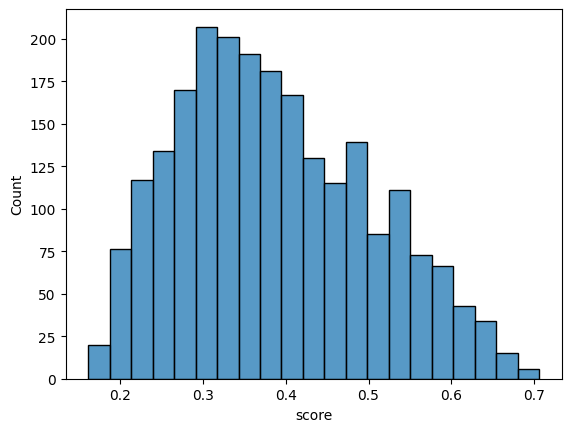

In [84]:
sns.histplot(preds["score"])

In [85]:
sub = test[["contract_id", "report_date"]]

In [86]:
sub = sub.merge(preds, left_on="contract_id", right_on='contract_id')

In [87]:
sub.to_csv('bin_clf.csv', index=False)